# Loading the dependencies

In [1]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch dataset
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data Loading and Exploration

We will start by loading the CIFAR-10 dataset that is targeted for this assignment. 
Then we can print a few images and get to know the data better.

## 1. Defining data augmentation transforms

We need to declare some transformations to the input images as a regularization technique.

Using:
- rotation of 15 degress
- color jitter
- horizontal flipping

We also need to resize the input images to the imagenet standard of 224x224

In [2]:
## Imagenet Normalization Parameter Standards
## transforms.Normalize(mean=[0.485, 0.456, 0.406],
##                           std=[0.229, 0.224, 0.225])

In [3]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize(224),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## 2. Load the CIFAR-10 Dataset
By default this comes with a 50K sample dataset for training and 10K for testing. 

Since the whole idea is to use transfer learning, we will cut 90% of the training dataset. This will make the training process way quicker and save a significant amount of resources.

In [4]:
# split into train and test
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=image_transforms['train'])
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=image_transforms['test'])

# just grab 10% of the training data
subset_idxs = torch.randperm(len(train_data))[:5000]

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

In [6]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    num_workers=num_workers,
    sampler=SubsetRandomSampler(indices=subset_idxs)
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

## 3. Visualize data

In [8]:
# helper function to un-normalize and display an image
def imshow(img):
    # unnormalize
    image = img.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    plt.imshow(np.clip(image, 0,1))

#IDX_TO_LABEL = {v: k for k, v in train_data.class_to_idx.items()}

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()
images = images.numpy() # convert images to numpy for display
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

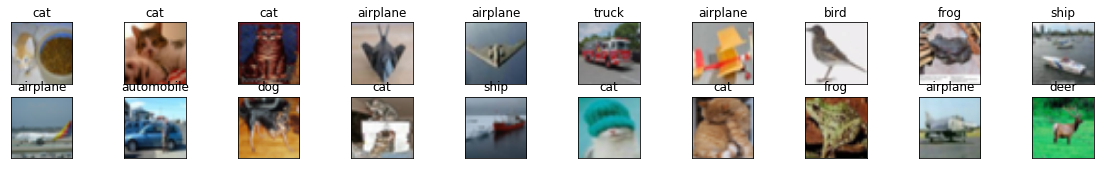

In [9]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 2.5))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(np.array(images[idx]))
    ax.set_title(classes[labels[idx]])
    ax.set_title(classes[labels[idx]])

# Model design and training
In today's Deep Learning world I think it is worth to try a transfer learning approach by loading a pre-trained architecture and training our own neural network classifier as the last layer of the pre-trained approach.

## 1. Choose a pre-trained model
After reading some similar tasks done in the past, I decided to use `VGG-19` as the pre-trained model. Today there are many other more advanced architectures outperforming this network but it is widely used in educational projects.


In [10]:
#models.list_models() not available in every version of torchvision

## 2. Load the pre-trained model

In [11]:
model = models.vgg19(pretrained=True) # legacy
#model = models.vgg19(weigths=models.VGG19_Weights.DEFAULT) # pytorch 0.16

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:06<00:00, 92190692.08it/s]


## 3. Design our own classifier module

The idea is to train the last layers with our own classifier, but for VGGs I've seen that only the last FC layer is replaced (classifier(6)).

VGG19 original classifier:
```python
"""(classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )"""
```

In [12]:
# define the classifier architecture
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features=4096, out_features=256, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(in_features=256, out_features=len(classes), bias=True)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # sequence for deep linear classifier
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

### 3.1 Freeze the model
Ensures only the replaced classifier gets trained.

In [13]:
for param in model.parameters():
    param.requires_grad = False

### 3.2 Plug the classifier into the model

In [14]:
#model.classifier[0].requires_grad = True #train layer before our classifier
model.classifier[3].requires_grad = True #train layer before our classifier
model.classifier[6] = Model()

### 3.3 Define Loss function and optimization

In [15]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()), lr=0.0002)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

## 4. Train the network

In [17]:
# number of epochs to train the model
n_epochs = 5
debug = True
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    train_acc = 0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)
        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Track average accuracy times the number of examples
        train_acc += accuracy.item() * data.size(0)
        ### DEBUG
        if not batch_idx % 50 and debug:
            print(f"""Epoch: {epoch}/{n_epochs} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss:.4f}""")
    # Calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    # Calculate average accuracy
    train_acc = train_acc / len(train_loader.sampler)
    # print training/validation statistics     
    print(f'Epoch {epoch} | Training Loss: {train_loss:.4f} | Training Accuracy: {100 * train_acc:.2f}%')


Epoch: 1/5 | Batch 0/157 | Loss: 2.3054
Epoch: 1/5 | Batch 50/157 | Loss: 1.0679
Epoch: 1/5 | Batch 100/157 | Loss: 0.8295
Epoch: 1/5 | Batch 150/157 | Loss: 0.6292
Epoch 1 | Training Loss: 1.0195 | Training Accuracy: 67.32%
Epoch: 2/5 | Batch 0/157 | Loss: 0.4894
Epoch: 2/5 | Batch 50/157 | Loss: 0.6679
Epoch: 2/5 | Batch 100/157 | Loss: 0.6253
Epoch: 2/5 | Batch 150/157 | Loss: 0.7624
Epoch 2 | Training Loss: 0.6533 | Training Accuracy: 77.12%
Epoch: 3/5 | Batch 0/157 | Loss: 0.4850
Epoch: 3/5 | Batch 50/157 | Loss: 0.5007
Epoch: 3/5 | Batch 100/157 | Loss: 0.4397
Epoch: 3/5 | Batch 150/157 | Loss: 0.8481
Epoch 3 | Training Loss: 0.5843 | Training Accuracy: 79.36%
Epoch: 4/5 | Batch 0/157 | Loss: 0.4493
Epoch: 4/5 | Batch 50/157 | Loss: 0.6319
Epoch: 4/5 | Batch 100/157 | Loss: 0.5929
Epoch: 4/5 | Batch 150/157 | Loss: 0.4844
Epoch 4 | Training Loss: 0.5429 | Training Accuracy: 80.46%
Epoch: 5/5 | Batch 0/157 | Loss: 0.4972
Epoch: 5/5 | Batch 50/157 | Loss: 0.4630
Epoch: 5/5 | Batch 

In [23]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
test_acc = 0
# Don't keep track of gradients
with torch.no_grad():
    model.eval()
    # iterate over test data
    for batch_idx, (data, target) in enumerate(test_loader):
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Track average accuracy times the number of examples
        test_acc += accuracy.item() * data.size(0)
        ### DEBUG
        if not batch_idx % 50 and debug:
            print(f"""Batch {batch_idx}/{len(test_loader)} | Loss: {loss:.4f}""")
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

#for i in range(10):
#    if class_total[i] > 0:
#        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
#            classes[i], 100 * class_correct[i] / class_total[i],
#            np.sum(class_correct[i]), np.sum(class_total[i])))
#    else:
#        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

test_acc = test_acc / len(test_loader.dataset)
print(f'Test Accuracy : {100 * test_acc:.2f}%')

Batch 0/313 | Loss: 0.3677
Batch 50/313 | Loss: 0.5697
Batch 100/313 | Loss: 0.8139
Batch 150/313 | Loss: 0.3682
Batch 200/313 | Loss: 0.4151
Batch 250/313 | Loss: 0.6636
Batch 300/313 | Loss: 0.4484
Test Loss: 0.530392

Test Accuracy : 81.43%


## Saving your model
Using `torch.save`, save your model for future loading.

In [24]:
torch.save(model.state_dict(), 'g6s_vgg_classifier.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy?

In today's image classification landscape, an accuracy of 80%+ can be achieved in a simple prototype using deep learning techniques lkie transfer learning.

By using this approach we could not just achieve a better performance than the vendor but we did so by using minimal amount of data (5000 samples) in minimal time.

* How does this compare to Detectocorp's model?
The model outperforms Detectocorp's model by 11% ish.
* How does it compare to the far more advanced solutions in the literature? 
VGG is a 2014 imagenet competition model so is fat by today's (2023) image classification models. AFAICT, SOTA models today can achieve 93+ % accuracy on imagenet.
These models such as vision transformers are open source and accesible via the same software, so improvement of this baseline transfer learning techinque can be easily applied to more advanced models.

* What did you do to get the accuracy you achieved?

  - we used a transfer learning approach to grab a pre-trained model and simplify our classifier model and optimize training.
  - we selected vgg19 for this exercise and loaded its pretrained version
  - we modeled a linear classifier with two fully connected layers that adapted to our CIFAR-10 classes
  - we replaced the last layer of the VGG with our liner classifier and trained just that layer with our trainin dataset.
  - we trained for 5 epochs on a batch size of 64

* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?
We could definitely improve the accuracy of this model by performing changing the approach of the architecture and training:

  - we could further augment the data by using rotations and grayscales. we see that doing this reduces the accuracy on the training on the first epochs but could be useful to generalize better.
  - we could train more data for more epochs
  - we could use a more advanced model as our feature detector
  - we could experiment with different linear classifiers